# Dataset 1 - Regression

## Import Libraries 

In [1]:
import train_test
import ABC_train_test
import regressionDataset
import network
import statsModel
import performanceMetrics
import dataset
import sanityChecks
import torch 
import matplotlib.pyplot as plt 
import seaborn as sns 
from scipy.stats import norm
from torch.utils.data import Dataset,DataLoader 
from torch import nn
import warnings
warnings.filterwarnings('ignore')

## Parameters

General Parameters 

1. Number of Samples 

Discriminator Parameters

1. Size : number of hidden nodes 

ABC-Generator parameters are as mentioned below: 
1. mean : 1 ($\beta \sim N(\beta^{*},\sigma)$ where $\beta^{*}$ are coefficients of statistical model) or 1 ($\beta \sim N(0,\sigma)$
2. std : $\sigma = 1, 0.1 , 0.01$ (standard deviation)

In [2]:
n_features = 10
sample_size = 100
#Discriminator Parameters 
hidden_nodes = 25 
#ABC Generator Parameters
mean = 1 
variance = 0.001

## Dataset

Generate a random regression problem

$Y = 1 + \beta_1 x_1 + \beta_2 x_2 + \beta_2 x_3 + ... + \beta_n x_n + N(0,\sigma)$ where $\sigma = 0.1$

In [3]:
X,Y = regressionDataset.regression_data(sample_size,n_features)

         X1        X2        X3        X4        X5        X6        X7  \
0 -1.003770  0.467473 -0.218651 -0.676265 -0.016443  0.780346 -1.078272   
1  0.547605  0.029382 -2.033179  0.028702 -0.491520  0.529759 -0.553983   
2  0.220598  1.192805  2.797058  0.571669  0.460904  0.486202 -2.335393   
3  0.184011 -0.167748 -1.242045 -0.081350  1.335627 -1.449922  0.481887   
4  1.464577 -1.529598  1.465365 -0.185177  2.035783 -0.050075 -1.274503   

         X8        X9       X10           Y  
0  0.538080 -0.295357  0.224507 -125.184155  
1  1.613541 -0.666623  1.439294  -54.744569  
2 -0.033403 -0.397156 -0.596488  287.954812  
3 -0.189243 -0.204796 -1.159570 -153.068164  
4  1.246308  1.063228 -0.063595  124.484165  


## Stats Model

No handles with labels found to put in legend.


                            OLS Regression Results                            
Dep. Variable:                      Y   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                  1.000
Method:                 Least Squares   F-statistic:                 5.308e+07
Date:                Thu, 07 Oct 2021   Prob (F-statistic):          6.27e-297
Time:                        18:58:22   Log-Likelihood:                 638.17
No. Observations:                 100   AIC:                            -1254.
Df Residuals:                      89   BIC:                            -1226.
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const               0   4.34e-05          0      1.0

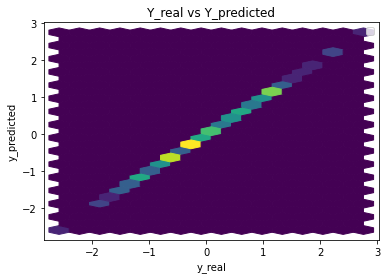

Performance Metrics
Mean Squared Error: 1.6768415750084017e-07
Mean Absolute Error: 0.0003160635816990504
Manhattan distance: 0.03160635816990504
Euclidean distance: 0.004094925609835179


In [4]:
[coeff,y_pred] = statsModel.statsModel(X,Y)

# Generator and Discriminator Networks 

**GAN Generator**

In [5]:
class Generator(nn.Module):

  def __init__(self,n_input):
    super().__init__()
    self.output = nn.Linear(n_input,1)

  def forward(self, x):
    x = self.output(x)
    return x 

**GAN Discriminator**

In [6]:
class Discriminator(nn.Module):

  def __init__(self,n_input,n_hidden):

    super().__init__()
    self.hidden = nn.Linear(n_input,n_hidden)
    self.output = nn.Linear(n_hidden,1)
    self.relu = nn.ReLU()

  def forward(self, x):
    x = self.hidden(x)
    x = self.relu(x)
    x = self.output(x)
    return x 

**ABC Generator**

The ABC generator is defined as follows:

$Y = 1 + \beta_1 x_1 + \beta_2 x_2 + \beta_2 x_3 + ... + \beta_n x_n + N(0,\sigma)$ where $\sigma = 0.1$ 

$\beta_i \sim N(0,\sigma^{*})$ when $\mu = 0$ else

$\beta_i \sim N(\beta_i^{*},\sigma^{*})$ where $\beta_i^{*}s$ are coefficients obtained from stats model

Parameters : $\mu$ and $\sigma^{*}$

$\sigma^{*}$ takes the values 0.01,0.1 and 1

In [7]:
def ABC_pre_generator(x_batch,coeff,variance,mean,device):

  coeff_len = len(coeff)

  if mean == 0:
    weights = np.random.normal(0,variance,size=(coeff_len,1))
    weights = torch.from_numpy(weights).reshape(coeff_len,1)
  else:
    weights = []
    for i in range(coeff_len):
      weights.append(np.random.normal(coeff[i],variance))
    weights = torch.tensor(weights).reshape(coeff_len,1)
    
  y_abc =  torch.matmul(x_batch,weights.float())
  gen_input = torch.cat((x_batch,y_abc),dim = 1).to(device)
  return gen_input 

# GAN Model

In [8]:
real_dataset = dataset.CustomDataset(X,Y)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [9]:
generator = Generator(n_features+2)
discriminator = Discriminator(n_features+2,hidden_nodes)

criterion = torch.nn.BCEWithLogitsLoss()
gen_opt = torch.optim.Adam(generator.parameters(), lr=0.01, betas=(0.5, 0.999))
disc_opt = torch.optim.Adam(discriminator.parameters(), lr=0.01, betas=(0.5, 0.999))

In [10]:
print(generator)
print(discriminator)

Generator(
  (output): Linear(in_features=12, out_features=1, bias=True)
)
Discriminator(
  (hidden): Linear(in_features=12, out_features=25, bias=True)
  (output): Linear(in_features=25, out_features=1, bias=True)
  (relu): ReLU()
)


In [11]:
n_epochs = 5000
batch_size = sample_size//2

In [12]:
# Parameters
sample_size = 1000000
mean = 1
std = 1


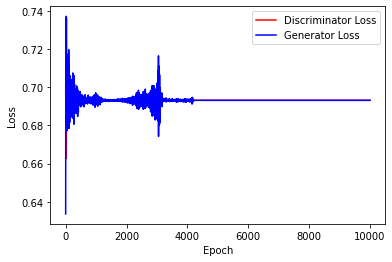

In [13]:
train_test.training_GAN(discriminator,generator,disc_opt,gen_opt,real_dataset,batch_size, n_epochs,criterion,device)

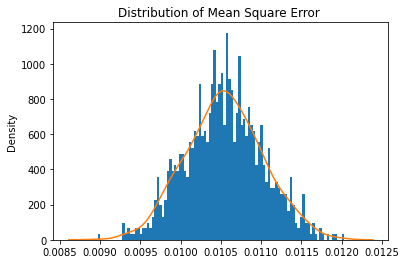

Mean Square Error: 0.010544361224138986


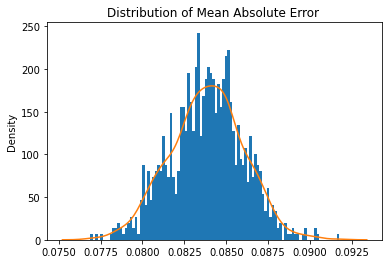

Mean Absolute Error: 0.08383256637070328


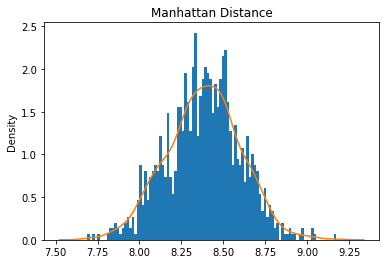

Mean Manhattan Distance: 8.383256637070328


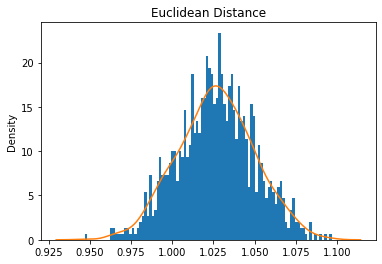

Mean Euclidean Distance: 8.383256637070328


In [14]:
train_test.test_generator(generator,real_dataset,device)

# ABC GAN Model

#### Training the network

In [15]:
gen = Generator(n_features+2)
disc = Discriminator(n_features+2,hidden_nodes)

criterion = torch.nn.BCEWithLogitsLoss()
gen_opt = torch.optim.Adam(gen.parameters(), lr=0.01, betas=(0.5, 0.999))
disc_opt = torch.optim.Adam(disc.parameters(), lr=0.01, betas=(0.5, 0.999))

In [16]:
n_epoch_abc = 2000
batch_size = sample_size//2

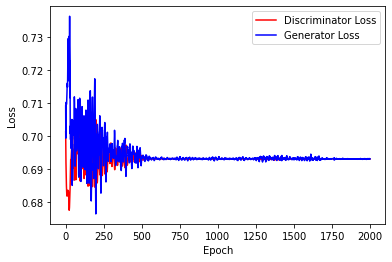

In [17]:
ABC_train_test.training_GAN(disc, gen,disc_opt,gen_opt,real_dataset, batch_size, n_epoch_abc,criterion,coeff,mean,variance,device)

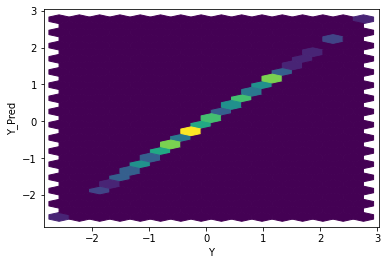

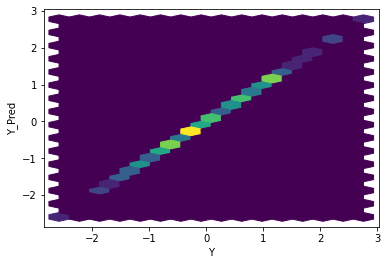

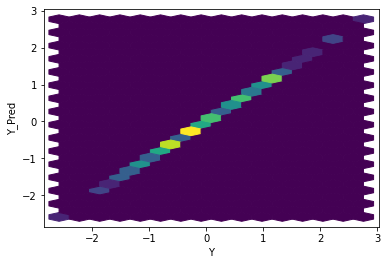

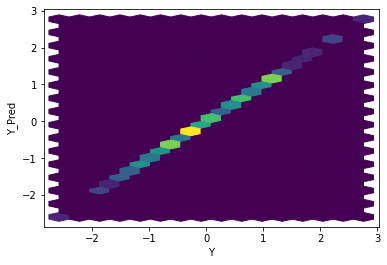

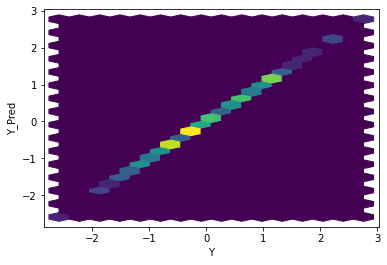

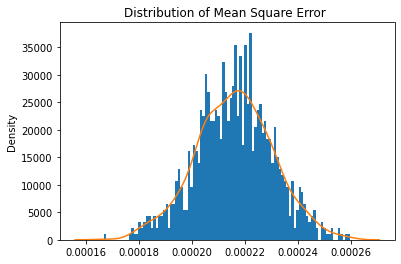

Mean Square Error: 0.0002159699530751817


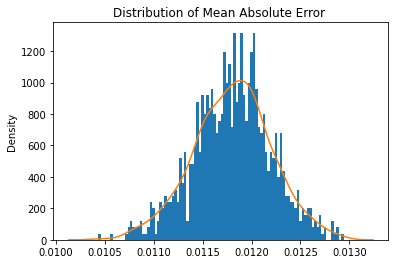

Mean Absolute Error: 0.01180549354068935


Mean Manhattan Distance: 1.180549354068935


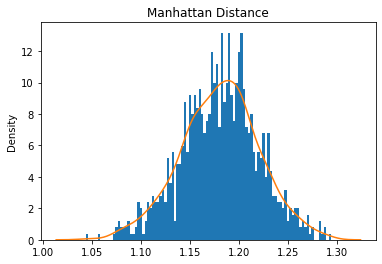

Mean Euclidean Distance: 0.1468753210802312


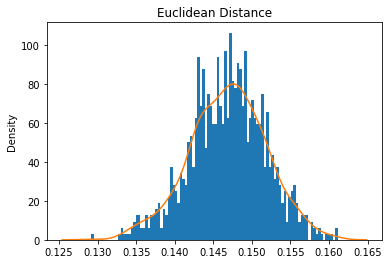

In [18]:
ABC_train_test.test_generator(gen,real_dataset,coeff,mean,variance,device)

#### Sanity Checks 

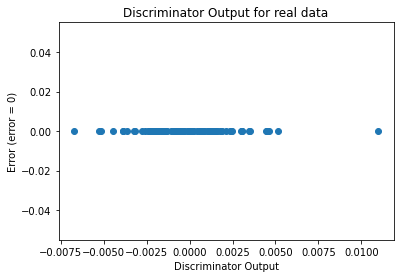

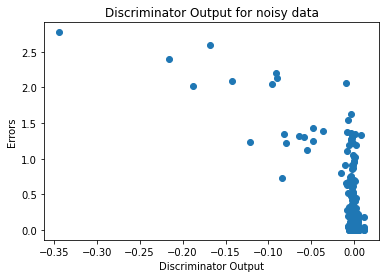

In [19]:
sanityChecks.discProbVsError(real_dataset,disc,device)

## Visualization of trained GAN generator 

In [20]:
for name, param in gen.named_parameters():
    print(name,param)

output.weight Parameter containing:
tensor([[0.0306, 0.2091, 0.2453, 0.1987, 0.1767, 0.0922, 0.0188, 0.0998, 0.0140,
         0.0513, 0.1694, 0.4933]], requires_grad=True)
output.bias Parameter containing:
tensor([-0.0276], requires_grad=True)
